In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability, log_probability_2flares, log_probability_2flares2ars
from funcs.helper import calculate_inclination

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")


import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [86]:
R_jup*.92/R_sun

<Quantity 0.09454167>

In [47]:
#tstamp = '13_12_2019_10_18'
tstamp

'20_02_2020_12_57'

In [93]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")

props = pd.read_csv(f"{CWD}/data/summary/properties.csv")

lcs = lcs.merge(props, left_on="ID", right_on="id")


lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[-1]

i_mu, i_sigma = calculate_inclination(target)
i_mu, i_sigma = i_mu.to("rad").value, i_sigma.to("rad").value
target

ID                    230120143
QCS                          16
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                  generic
h_mission                  TESS
SpT                          M7
view_start                 1741
view_stop                  1743
view_min                   2320
view_max                   2500
BJDoff                  2457000
tstart                  1741.62
ampl_min                    1.5
ampl_max                    2.5
RA                      250.086
Dec                     67.6013
J                         9.854
R                           NaN
Gaia_G                   13.557
vsini_kms                  10.8
e_vsini_kms                 0.7
Prot_d                 0.378325
sini                  0.6844128
Ref                Kesseli+2018
identifier                  NaN
Rstar                       NaN
idtyp                      tess
id                    230120143
st      

In [94]:
i_mu/np.pi*180

24.02478912140365

In [95]:
i_mu

0.41931167226580934

5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 230120143 modulation period:  9.089056409968848 h
Relative amplitude of modulation: -3.7e-03
[1738.65173791 1738.6531268  1738.65451569 ... 1763.31571967 1763.31710857
 1763.31849747]
[11.266142 11.266142 11.266142 ... 11.266142 11.266142 11.266142]


2352.491108184261

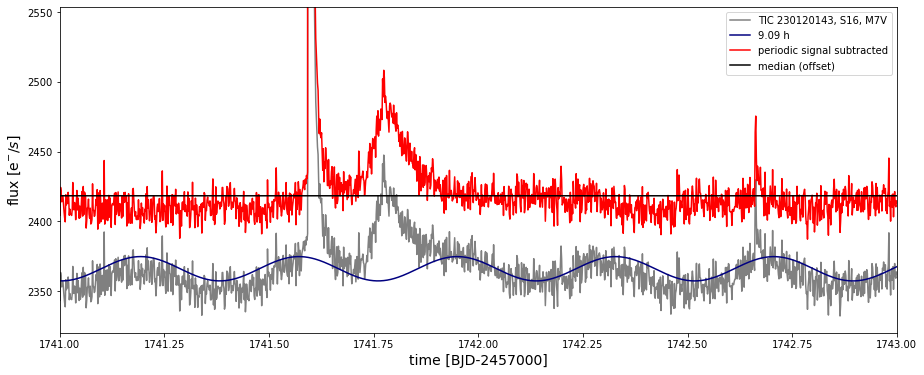

In [96]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
#from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False,)# cut=[target.view_start-5,target.view_stop+5])
print(t)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = F#refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                    # std_rolling_window_length=15, pad=25)

choice = (t > target.view_start +.25) & (t < target.view_stop-.25) # only one flare in TIC 237 : + 1.56 - 1.
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med-10)
phi = (t - t[0])/target.Prot_d * 2 * np.pi

pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

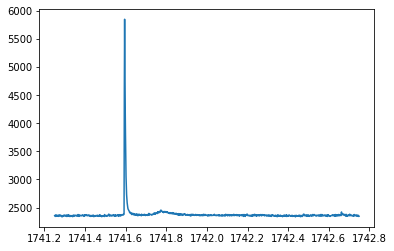

In [97]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(lc.t, lc.flux)

(2300, 2700)

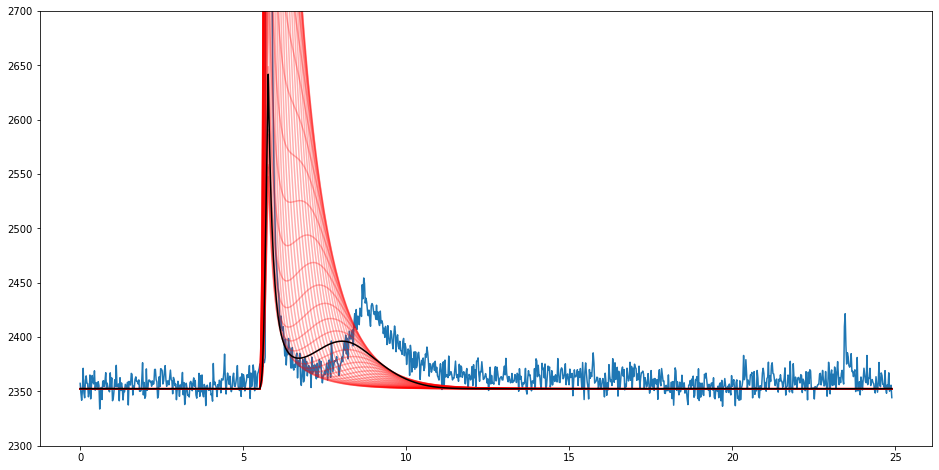

In [98]:

phi_a = (target.tstart- t[0]-.0275)/target.Prot_d * 2 * np.pi
theta_a = 15*np.pi/180#target.theta_a_init
a = 2.6
fwhm =  .03/target.Prot_d * 2 * np.pi
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = -180* np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(phi,flux)
for i in range(-180,180,10):
    plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i* np.pi / 180,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(2300,2700)

### Save inits

In [45]:
log_probs = {"log_probability":[6, log_probability],
             "log_probability_2flares":[9, log_probability_2flares],
             "log_probability_2flares2ars":[10, log_probability_2flares2ars],}

log_prob = "log_probability"
nparam = log_probs[log_prob][0]

with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)

## Run MCMC

In [ ]:
from funcs.flarefit import (log_probability,
                            log_probability_2flares,
                            log_probability_2flares2ars)

log_probs = {"log_probability":[6, log_probability],
             "log_probability_2flares":[9, log_probability_2flares],
             "log_probability_2flares2ars":[10, log_probability_2flares2ars],}






# Keyword arguments Nsteps = 50000

def run_mcmc(Nsteps=50000, wiggle=1e-3):

    inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
    target = inits.loc[inits.ID == ID,:]
    ndim = target.nparam
    nwalkers = 32


    inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
    pos = inits * (1. + wiggle * np.random.randn(nwalkers, target.nparam))

    # Set up the backend
    # Don't forget to clear it in case the file already exists
    filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)


    sampler = emcee.EnsembleSampler(nwalkers, target.nparam, log_probability,
                                    args=(phi, flux, flux_err, target.qlum,
                                          target.Fth, target.R_Rsun, target.median,
                                          {"i_mu":target.i_mu,
                                          "i_sigma":target.i_sigma}),
                                    backend=backend)

    sampler.run_mcmc(pos, Nsteps, progress=True, store=True);



if __name__ == "__main__":
# Read ID from keyboard here

# 

In [ ]:
from funcs.flarefit import log_probability
ndim = 6
nwalkers = 32


inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(nwalkers, ndim))

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma}),
                                backend=backend)

In [ ]:
print(f"MCMC run at {tstamp}\n\nlight curve file: {filename}")

## Resume MCMC after break

In [ ]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

In [ ]:
tstamp, target.ID

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(phi, flux, flux_err, 
                                          qlum, Fth, R, median, 
                                          {"i_mu":i_mu, "i_sigma":i_sigma, }),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))